In [1]:
import os
import logging
from pytz import timezone
from datetime import datetime
import numpy as np

from data_loader import SyntheticDataset
from models import NoTears
from trainers import ALTrainer
from helpers.config_utils import save_yaml_config, get_train_args
from helpers.log_helper import LogHelper
from helpers.tf_utils import set_seed
from helpers.dir_utils import create_dir
from helpers.analyze_utils import count_accuracy, plot_estimated_graph

# For logging of tensorflow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import pandas as pd

ex_name = 'DEGs'

headers = pd.read_csv('DEGs.csv', nrows=0).columns.tolist()
headers = [c for c in headers if c != 'Samples']

df = pd.read_csv("DEGs.csv", usecols=headers)
df = df.fillna(-1).reset_index(drop=True)
df = (df-df.mean())/df.std()
X = df.to_numpy()

X.shape

(203, 282)

In [3]:
df

,Tumor,CHEK1,PRSS1,SPARC,TNFRSF6B,SERPINE2,COL12A1,SERPINE1,NUDT1,IFI35,...,CTHRC1,SNCA,CMTM3,LUM,MUC5B,SORL1,SOD1,COL7A1,CD9,CKLF
0,-0.494156,-0.325218,-0.344538,-0.375498,-0.267146,-0.249739,-0.358675,-0.419971,-0.386909,-0.526466,...,-0.339612,-0.309732,-0.411442,-0.392023,-0.230606,-0.431868,-0.545528,-0.302550,-0.198374,-0.450340
1,-0.494156,-0.472615,1.762292,-0.477040,-0.284185,-0.286044,-0.414569,-0.163772,-0.380183,-0.502588,...,-0.364651,-0.271490,-0.509273,-0.423449,-0.236653,-0.535287,-0.483912,-0.275547,-0.233646,-0.452821
2,-0.494156,-0.475582,0.563075,-0.393478,-0.296221,-0.274506,-0.402205,0.059891,-0.403918,-0.454485,...,-0.360611,-0.312498,-0.436521,-0.409008,-0.239081,-0.479486,-0.484074,-0.291994,-0.181844,-0.417950
3,-0.494156,-0.511936,-0.466030,-0.498666,-0.263709,-0.270498,-0.447176,-0.334975,-0.586130,-0.470591,...,-0.372073,-0.280698,-0.481809,-0.440325,-0.234158,-0.461926,-0.435102,-0.272092,-0.219688,-0.470041
4,-0.494156,-0.304629,0.630809,-0.342282,-0.265100,-0.270464,-0.354839,0.126089,-0.320438,-0.391490,...,-0.232529,-0.209356,-0.321497,-0.302834,-0.239902,-0.268287,-0.404589,-0.302571,-0.166657,-0.340193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2.013685,1.840251,-1.506282,0.431568,1.616545,0.649541,0.902882,0.414254,4.119182,7.424456,...,0.514220,-0.185561,3.058651,0.685974,0.682769,2.184615,3.173095,0.971970,1.439072,4.263122
199,2.013685,0.313463,-1.507044,3.527021,-0.296221,3.488880,2.384345,2.089834,1.130382,0.214439,...,2.060675,2.732750,1.170524,2.479979,-0.240497,1.101337,0.712381,-0.125300,0.716722,-0.008113
200,2.013685,1.460989,-1.505102,0.452003,0.296774,-0.161074,0.198878,-0.203324,1.411048,1.768291,...,0.303502,-0.099164,1.209179,0.307345,-0.098479,1.890273,4.176878,1.474482,0.339041,2.437891
201,2.013685,3.332453,-1.506992,1.424003,-0.236912,0.138869,1.835621,-0.012652,1.412054,1.196117,...,0.489568,-0.279081,0.444098,0.976663,0.943222,1.562662,2.323360,0.566633,0.294612,1.447282


In [4]:
# Get arguments parsed
args = get_train_args()

args.n = X.shape[0]
args.d = X.shape[1]

In [5]:
# Setup for logging
output_dir = 'output/{}/{}'.format(ex_name, datetime.now(timezone('Asia/Taipei')).strftime('%Y-%m-%d_%H-%M-%S-%f')[:-3])
create_dir(output_dir)
LogHelper.setup(log_path='{}/training.log'.format(output_dir), level_str='INFO')
_logger = logging.getLogger(__name__)

# Save the configuration for logging purpose
save_yaml_config(args, path='{}/config.yaml'.format(output_dir))

# Reproducibility
set_seed(args.seed)

# Get dataset
dataset = SyntheticDataset(args.n, args.d, args.graph_type, args.degree, args.sem_type,
                           args.noise_scale, args.dataset_type)
_logger.info('Finished generating dataset')

2022-04-02 09:59:54,501 INFO - helpers.log_helper - Finished configuring logger.
2022-04-02 09:59:54,521 INFO - __main__ - Finished generating dataset


In [6]:
dataset.X = X
X

array([[-0.49415576, -0.32521805, -0.34453847, ..., -0.30255031,
        -0.19837427, -0.45034043],
       [-0.49415576, -0.47261504,  1.76229235, ..., -0.27554706,
        -0.2336465 , -0.45282053],
       [-0.49415576, -0.47558224,  0.56307492, ..., -0.29199405,
        -0.18184364, -0.41794978],
       ...,
       [ 2.01368471,  1.46098869, -1.50510226, ...,  1.47448166,
         0.3390408 ,  2.43789141],
       [ 2.01368471,  3.33245344, -1.50699248, ...,  0.56663259,
         0.29461182,  1.44728164],
       [ 2.01368471,  0.28164732, -1.50588735, ...,  0.76367987,
        -0.21133766,  0.14935127]])

In [7]:
model = NoTears(args.n, args.d, args.seed, args.l1_lambda, args.use_float64)
model.print_summary(print_func=model.logger.info)

trainer = ALTrainer(args.init_rho, args.rho_max, args.h_factor, args.rho_multiply,
                    args.init_iter, args.learning_rate, args.h_tol)
W_est = trainer.train(model, dataset.X, dataset.W, args.graph_thres,
                      args.max_iter, args.iter_step, output_dir)
_logger.info('Finished training model')

2022-04-02 09:59:55,234 INFO - models.notears - Model summary:
2022-04-02 09:59:55,234 INFO - models.notears - ---------
2022-04-02 09:59:55,235 INFO - models.notears - Variables: name (type shape) [size]
2022-04-02 09:59:55,235 INFO - models.notears - ---------
2022-04-02 09:59:55,236 INFO - models.notears - Variable:0 (float32 282x282) [79524, bytes: 318096]
2022-04-02 09:59:55,236 INFO - models.notears - Total size of variables: 79524
2022-04-02 09:59:55,237 INFO - models.notears - Total bytes of variables: 318096
2022-04-02 09:59:55,282 INFO - trainers.al_trainer - Started training for 20 iterations
2022-04-02 09:59:55,283 INFO - trainers.al_trainer - rho 1.000E+00, alpha 0.000E+00
2022-04-02 10:00:02,237 INFO - trainers.al_trainer - [Iter 1] loss 1.941E+00, mse 7.537E+02, acyclic 4.101E-01, shd 684, tpr 0.000, fdr 1.000, pred_size 149
2022-04-02 10:00:02,238 INFO - trainers.al_trainer - rho 1.000E+00, alpha 4.101E-01
2022-04-02 10:00:08,747 INFO - trainers.al_trainer - rho 1.000E+

In [8]:
# Save raw estimated graph, ground truth and observational data after training
np.save('{}/true_graph.npy'.format(output_dir), dataset.W)
np.save('{}/X.npy'.format(output_dir), dataset.X)
np.save('{}/final_raw_estimated_graph.npy'.format(output_dir), W_est)

In [9]:
W_est

array([[ 0.00000000e+00, -2.88136721e-06,  9.45569295e-03, ...,
         3.57306408e-06, -4.03706599e-06,  1.95663015e-05],
       [-5.73918298e-02,  0.00000000e+00,  5.12331501e-02, ...,
         4.81576845e-02,  1.99593864e-02,  1.46953043e-05],
       [ 6.32190437e-04, -6.39532436e-06,  0.00000000e+00, ...,
         7.34857349e-06,  1.07588789e-06, -3.41434679e-06],
       ...,
       [ 1.27242401e-01,  2.03601405e-04, -3.15878238e-03, ...,
         0.00000000e+00,  4.82746691e-05,  5.73836223e-05],
       [-7.66400471e-02,  3.07492046e-05, -1.79905728e-01, ...,
        -2.29252540e-02,  0.00000000e+00,  1.49854659e-05],
       [-1.25726938e-01, -4.26061712e-02, -1.24999896e-01, ...,
         6.21762360e-03,  2.12149456e-01,  0.00000000e+00]], dtype=float32)

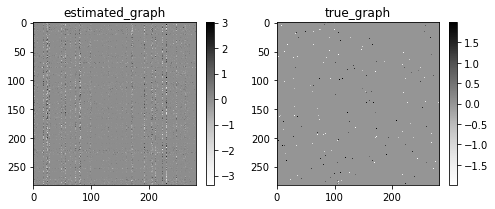

2022-04-02 10:01:57,283 INFO - __main__ - Thresholding.


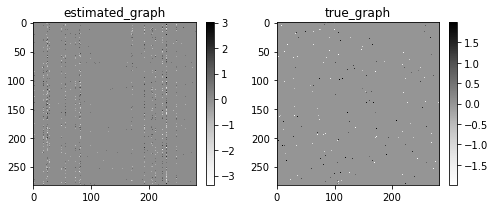

2022-04-02 10:01:57,592 INFO - __main__ - Results after thresholding by 0.5: {'fdr': 0.9950181159420289, 'tpr': 0.020522388059701493, 'fpr': 0.05621082256620187, 'shd': 2697, 'pred_size': 2208}


In [10]:
# Plot raw estimated graph
plot_estimated_graph(W_est, dataset.W,
                     save_name='{}/raw_estimated_graph.png'.format(output_dir))

_logger.info('Thresholding.')
# Plot thresholded estimated graph
args.graph_thres = 0.5
copy_W_est = W_est
copy_W_est[np.abs(W_est) < args.graph_thres] = 0   # Thresholding
plot_estimated_graph(copy_W_est, dataset.W,
                     save_name='{}/thresholded_estimated_graph.png'.format(output_dir))
results_thresholded = count_accuracy(dataset.W, W_est)
_logger.info('Results after thresholding by {}: {}'.format(args.graph_thres, results_thresholded))

In [11]:
c = np.sum(copy_W_est, axis=1)
c.shape

(282,)

In [12]:
x = np.abs(c) > 1
x[0] = True
x[1] = True
len(c[x])

166

In [13]:
bcp = copy_W_est[x,:][:,x]
print(bcp.shape)
headers = np.array(headers)
headers[x]

(166, 166)


array(['Tumor', 'CHEK1', 'SPARC', 'TNFRSF6B', 'NUDT1', 'IFI35', 'ENO1',
       'ENO2', 'ACTB', 'LGALS4', 'LGALS3', 'TNFSF10', 'LGALS9', 'B2M',
       'ACTN1', 'CLEC11A', 'FLT3LG', 'ACTN4', 'MIF', 'HLA-F', 'HSPG2',
       'HLA-E', 'DKK3', 'SFRP4', 'TWSG1', 'SFRP2', 'EZR', 'NBL1', 'CFB',
       'PLA1A', 'LXN', 'CFH', 'TGFA', 'C2', 'APOO', 'PRDX5', 'BLOC1S1',
       'S100A16', 'PRDX1', 'S100A13', 'SERPINH1', 'HMOX1', 'S100A14',
       'APOE', 'CD14', 'S100A10', 'ST14', 'FN1', 'LIF', 'NMI', 'LYZ',
       'COL1A2', 'COL9A2', 'HLA-DRB1', 'ITM2B', 'PIGR', 'GPI', 'ECM1',
       'SERPINA1', 'CTSZ', 'CTSV', 'LRRC32', 'AREG', 'CX3CL1', 'C1QTNF1',
       'GLIPR2', 'CTSK', 'C1QTNF5', 'MMP28', 'MUC13', 'CTSH', 'QSOX1',
       'TIMP1', 'CLIC1', 'CTSD', 'ANXA1', 'TPI1', 'ANXA2', 'BGN', 'MMEL1',
       'SERPINB8', 'F5', 'MMP14', 'CEACAM6', 'TFF3', 'TFF2', 'FAM20A',
       'ALDOA', 'APCS', 'CSTB', 'CD63', 'GSTP1', 'GBA', 'CAPG', 'FSTL1',
       'SRPX2', 'FRZB', 'AGR2', 'APOL1', 'CBR3', 'CCL21', 'F12', '

In [14]:
#result_matrix = pd.read_csv("W_true.csv", header=None)

In [15]:
#!apt-get update && apt-get install -y graphviz
#!pip install lingam

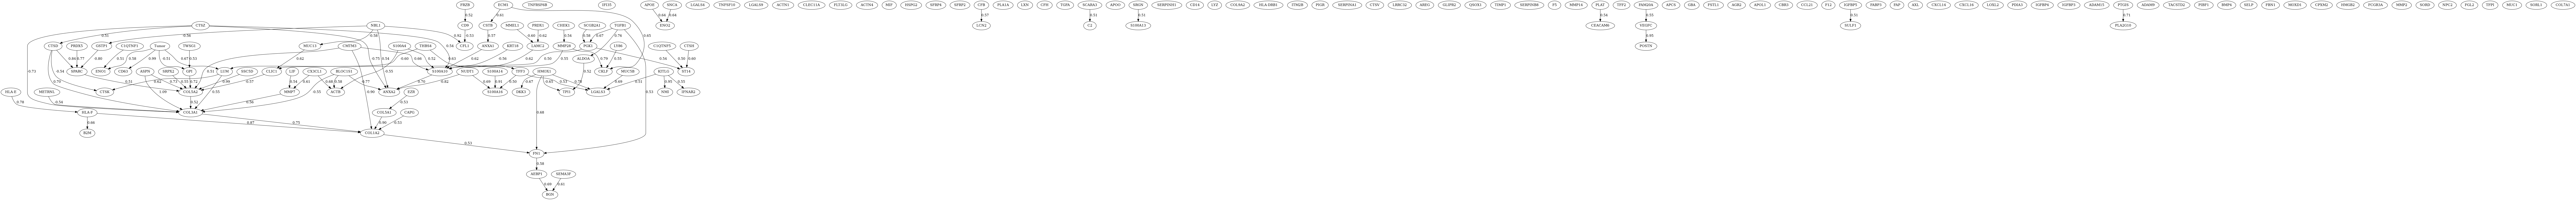

In [16]:
from lingam.utils import make_dot

dot = make_dot(bcp, labels=headers[x].tolist(), lower_limit=0.5)

# Save png
dot.format = 'png'
dag_path = dot.render('dag')

from IPython.display import Image
Image(filename=dag_path) 